In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import mcu
import simple_angles_dataset_generator as simple_angles_gen
import dataset_generator


In [37]:
figure_num = 300
figure_point_cnt = 300
deterministic_param_scatter = False
p = 3
noise_level = 0
lw = np.array([40, 0, 0])
up = np.array([120, 45, 45])
param_names = np.array(["inside_angle", "rotation_angle_x", "rotation_angle_y"])
control_vars = dataset_generator.get_control_vars(deterministic=deterministic_param_scatter, dimensionality=p,
                                                  size=figure_num,
                                                  lw=lw, up=up)
control_vars_dict = dataset_generator.put_control_vars_in_dict(control_vars, p, param_names)
figures = dataset_generator.generate_array_of_figures(control_vars_dict, simple_angles_gen.generate_angles_points,
                                                      noise_level=noise_level, min_num_points=figure_point_cnt)
k = 6
c = 10000
standardized_x, centered_y, edges, y_means, y_scaler, x_means, x_stds = mcu.prepare_data(control_vars, figures, k)

q = mcu.solve_semidefinite_programming(standardized_x, centered_y, edges, c)

0.019857046672767335


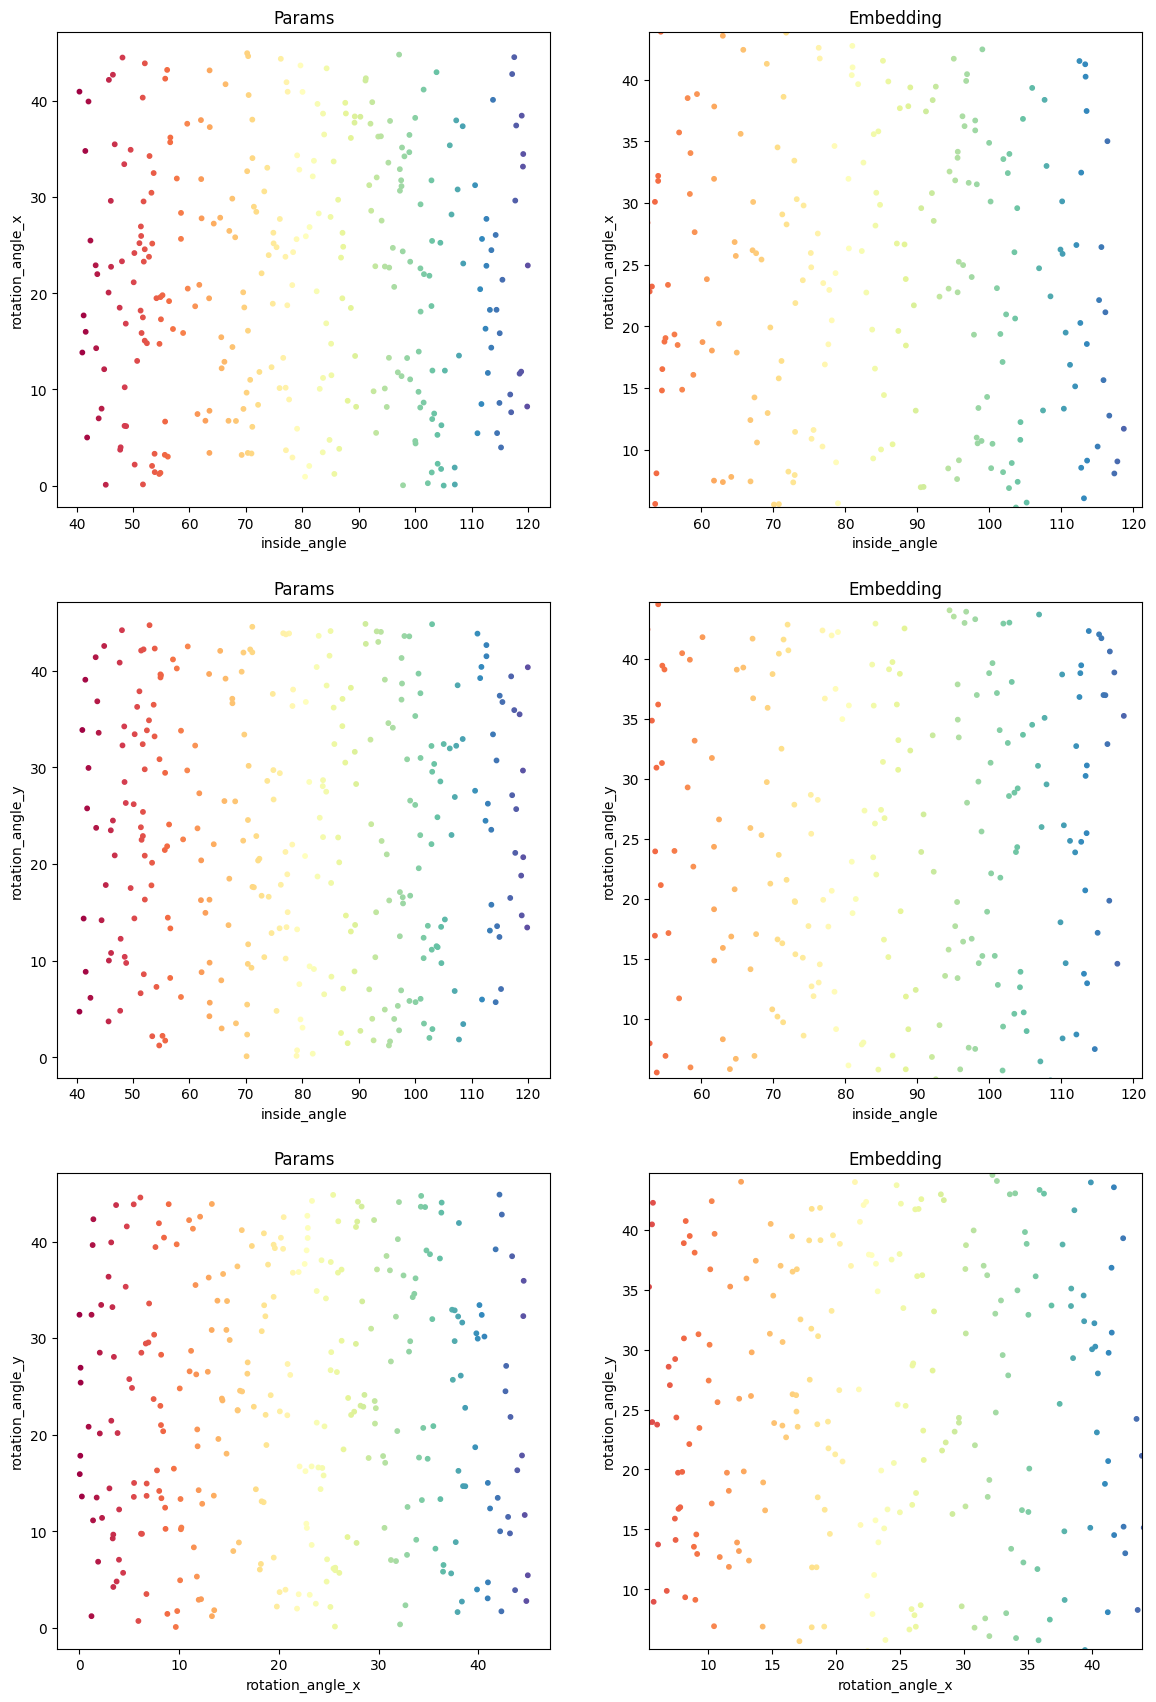

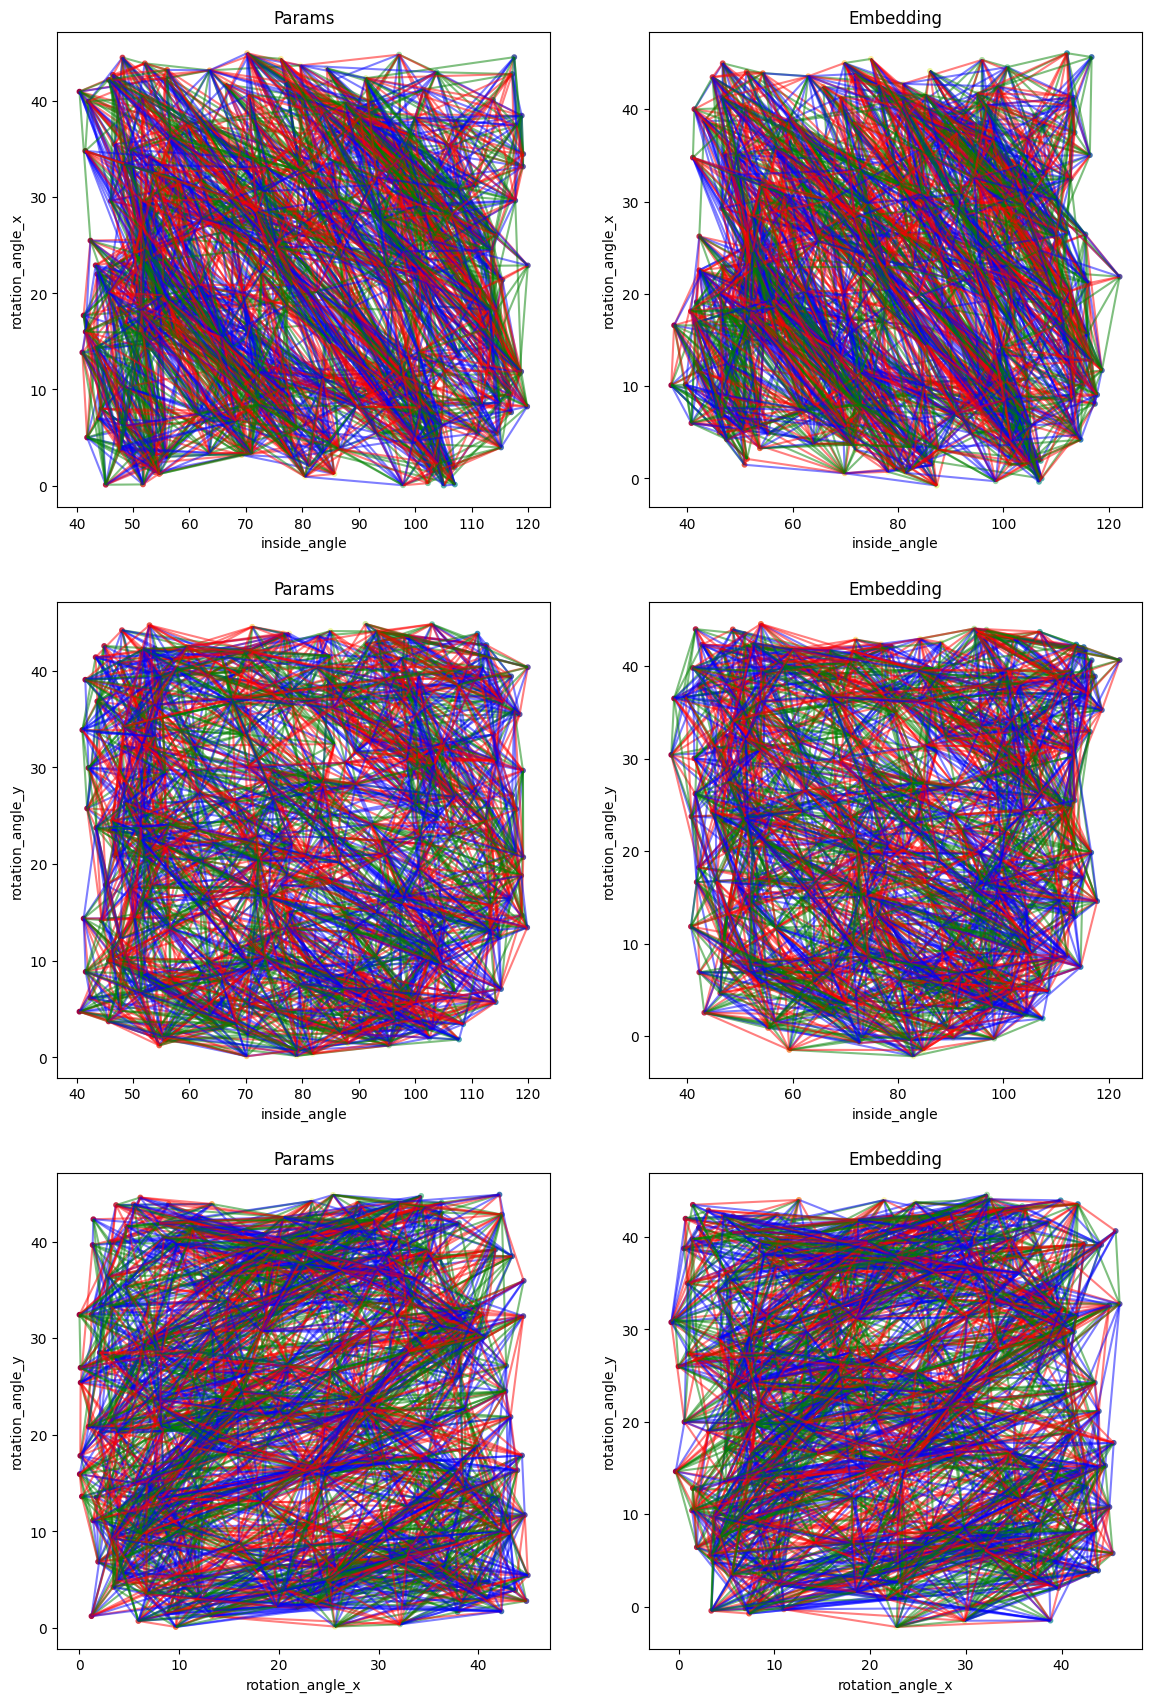

In [32]:
ld_embedding = mcu.reduce_dimensions(q, p)
regression_matrix = mcu.regress(ld_embedding, standardized_x)
reconstructed_y = np.dot(standardized_x, regression_matrix)

ld_embedding_to_params = np.dot(ld_embedding, np.linalg.inv(regression_matrix)) * x_stds + x_means

rre = mcu.compute_rre(ld_embedding_to_params, control_vars)
print(np.median(rre))
mcu.plot_embeddings_vs_parameters(embedding=ld_embedding_to_params, params=control_vars, param_names=param_names)
mcu.plot_embeddings_vs_parameters(embedding=ld_embedding_to_params, params=control_vars, param_names=param_names,
                                  edges=edges)

In [35]:
pieces_cnt = 5
test_data_size = 20
noise_level = 0.01
interval_runs, intervals = mcu.test_predictive_optimization(lw, up, p, k, simple_angles_gen.generate_angles_points,
                                                            figure_point_cnt,
                                                            centered_y, ld_embedding, regression_matrix, y_means,
                                                            y_scaler,
                                                            x_stds, x_means, param_names, noise_level, pieces_cnt,
                                                            test_data_size,
                                                            same_value=False)

-----------
x_opt  = [50.15145012  5.06328543  7.57063663], x_err = 66.13779175604823
x_real = [42.80962556  4.69314009  2.81824397]
-----------
x_opt  = [59.46160001  5.06328543  7.20100473], x_err = 107.61880050447077
x_real = [40.67330541  4.3777782   1.95023017]
-----------
x_opt  = [50.15145012  5.06328543  6.48793951], x_err = 23.716998925452337
x_real = [51.83243978  0.12169856  1.72252517]
-----------
x_opt  = [50.15145012  5.06328543  5.67854133], x_err = 153.2806464624024
x_real = [40.64724829  7.41091502  0.96730868]
-----------
x_opt  = [50.15145012  5.06328543  7.5204275 ], x_err = 28.332762676373292
x_real = [49.26082426  1.72677069  2.42450837]
-----------
x_opt  = [50.15145012  7.99400139  5.67854133], x_err = 5.180926905685381
x_real = [49.95628376  6.63181199  1.82026435]
-----------
x_opt  = [50.15145012  5.06328543 11.17344973], x_err = 21.38936072193708
x_real = [43.50656957  6.48904511  6.66833845]
-----------
x_opt  = [51.96987474  5.06328543  7.99140341], x_err 

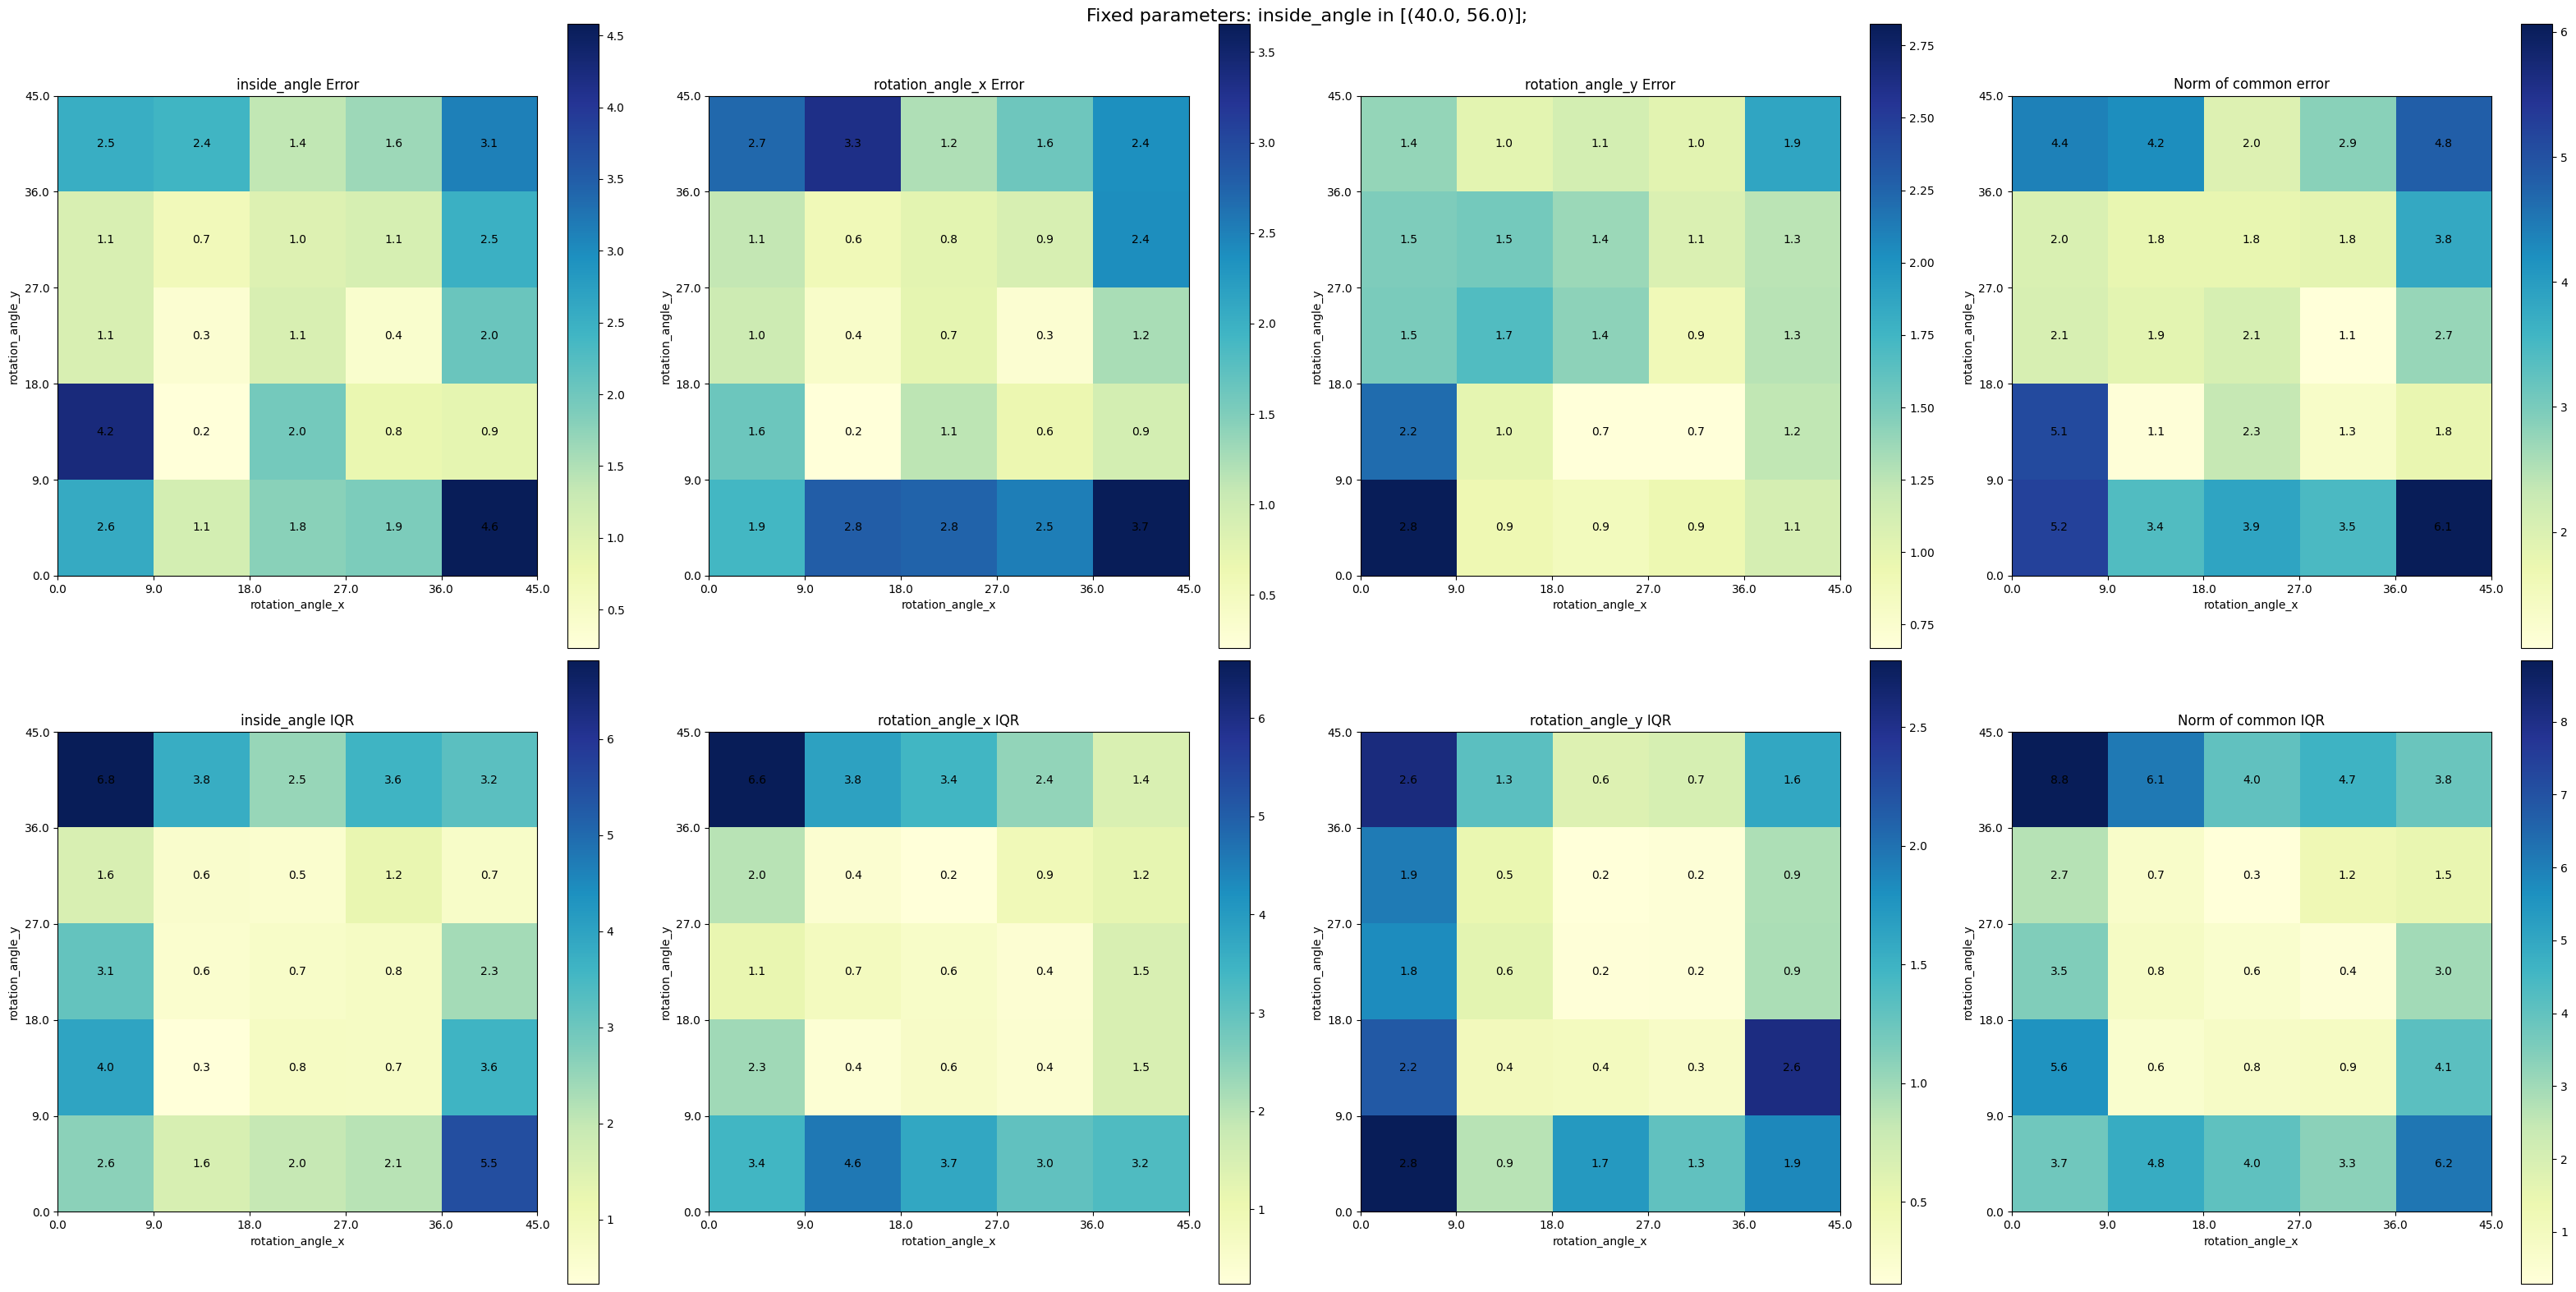

In [36]:
mcu.plot_2d_predictive_optimization_heatmaps(lw, up, pieces_cnt, interval_runs, p, param_names, fixed_params_map={0: 2},
                                             intervals=intervals)